##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License").

# DCGAN: An example with tf.keras and eager

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/generative_examples/dcgan.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

This notebook demonstrates how to generate images of handwritten digits using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager). To do so, we use Deep Convolutional Generative Adverserial Networks ([DCGAN](https://arxiv.org/pdf/1511.06434.pdf)).

This model takes about ~30 seconds per epoch (using tf.contrib.eager.defun to create graph functions) to train on a single Tesla K80 on Colab, as of July 2018.

Below is the output generated after training the generator and discriminator models for 150 epochs.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

In [1]:
# to generate gifs
!pip install imageio

    100% |████████████████████████████████| 3.3MB 11.4MB/s 
  Running setup.py bdist_wheel for imageio ... done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Import TensorFlow and enable eager execution

In [3]:


from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()
print(tf.__version__)

import os
from os import listdir
from os.path import isfile, join

import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
import random

1.10.1


## Load the dataset

We are going to use the MNIST dataset to train the generator and the discriminator. The generator will then generate handwritten digits.

814 40x30 sprites
814 256x256 sprites


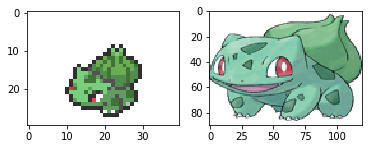

In [8]:
pixel_art_folder = "../input/pixel_art/40x30/" #cloud run
#pixel_art_folder = "D:\my_things/pkspritifier/40x30/" #local run
source_art_folder = "../input/pixel_art/256x256/" #cloud run
#pixel_art_folder = "D:\my_things/pkspritifier/256x256/" #local run




def gen_target_filenames():
    filenames = listdir(pixel_art_folder)
    num_sprites = len(filenames) 
    print(num_sprites, "40x30 sprites")
    for i,f in enumerate(filenames):
        yield (pixel_art_folder+f)
        
def gen_source_filenames():
    filenames = listdir(source_art_folder)
    num_sprites = len(filenames) 
    print(num_sprites, "256x256 sprites")
    for i,f in enumerate(filenames):
        yield (source_art_folder+f)



# something buggy about these...?
# target_filename_dataset = tf.data.Dataset.from_generator(gen_target_filenames,((tf.string)))
# source_filename_dataset = tf.data.Dataset.from_generator(gen_source_filenames,((tf.string)))

#alternative, in python
target_filenames = sorted(list(i for i in gen_target_filenames()))
source_filenames = sorted(list(i for i in gen_source_filenames()))

target_filename_dataset = tf.data.Dataset.from_tensor_slices(target_filenames)
source_filename_dataset = tf.data.Dataset.from_tensor_slices(source_filenames)


def parse_40x30 (filepath):
    pic = tf.read_file(filepath)
    pic = tf.image.decode_png(pic,channels = 4)
    pic = (tf.cast(np.array(pic),tf.float32)-127.5)/127.5
    return pic
  
def parse_256x256 (filepath):
    pic = PIL.Image.open(filepath)
    pic = pic.resize((120,90),PIL.Image.BICUBIC)
    pic = (tf.cast(np.array(pic),tf.float32)-127.5)/127.5
    
    return pic
  
target_images = list(parse_40x30(i) for i in target_filenames)
source_images = list(parse_256x256(i) for i in source_filenames)

target_dataset = target_filename_dataset.from_tensor_slices(target_images).batch(32)
source_dataset = source_filename_dataset.from_tensor_slices(source_images).batch(32)

a = np.array(iter(target_dataset).next()[0])
b = np.array(iter(source_dataset).next()[0])

fig, (target, source) = plt.subplots(ncols = 2)
target.imshow(((a.reshape((30,40,4))+1)/2))
source.imshow(((b.reshape((90,120,4))+1)/2))

## Write the generator and discriminator models

* **Generator** 
  * It is responsible for **creating convincing images that are good enough to fool the discriminator**.
  * It consists of Conv2DTranspose (Upsampling) layers. We start with a fully connected layer and upsample the image 2 times so as to reach the desired image size (mnist image size) which is (28, 28, 1). 
  * We use **leaky relu** activation except for the **last layer** which uses **tanh** activation.
  
* **Discriminator**
  * **The discriminator is responsible for classifying the fake images from the real images.**
  * In other words, the discriminator is given generated images (from the generator) and the real MNIST images. The job of the discriminator is to classify these images into fake (generated) and real (MNIST images).
  * **Basically the generator should be good enough to fool the discriminator that the generated images are real**.

In [9]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.conv0 = tf.keras.layers.Conv2D(128, (1, 1), strides=(3, 3), padding='same', use_bias=False)
    self.conv1 = tf.keras.layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.conv2 = tf.keras.layers.Conv2D(32, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.conv3 = tf.keras.layers.Conv2D(16, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.conv4 = tf.keras.layers.Conv2D(16, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.conv5 = tf.keras.layers.Conv2D(8, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.conv6 = tf.keras.layers.Conv2D(8, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.conv7 = tf.keras.layers.Conv2D(8, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.conv8 = tf.keras.layers.Conv2D(4, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    
    
    self.batchnorm0 = tf.keras.layers.BatchNormalization()
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    self.batchnorm4 = tf.keras.layers.BatchNormalization()
    self.batchnorm5 = tf.keras.layers.BatchNormalization()
    self.batchnorm6 = tf.keras.layers.BatchNormalization()
    self.batchnorm7 = tf.keras.layers.BatchNormalization()
    self.batchnorm8 = tf.keras.layers.BatchNormalization()

  def call(self, x, training=True):

    x = self.conv0(x)
    x = self.batchnorm0(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv1(x)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.relu(x)
    
    x = self.conv2(x)
    x = self.batchnorm2(x, training=training)
    x = tf.nn.relu(x)
    
    x = self.conv3(x)
    x = self.batchnorm3(x, training=training)
    x = tf.nn.relu(x)
    
    x = self.conv4(x)
    x = self.batchnorm4(x, training=training)
    x = tf.nn.relu(x)
    
    x = self.conv5(x)
    x = self.batchnorm5(x, training=training)
    x = tf.nn.relu(x)
    
    x = self.conv6(x)
    x = self.batchnorm6(x, training=training)
    x = tf.nn.relu(x)
    
    x = self.conv7(x)
    x = self.batchnorm7(x, training=training)
    x = tf.nn.relu(x)
    
    x = self.conv8(x)
    x = tf.nn.tanh(x)
    return x

In [10]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(64, (1, 1), strides=(2, 2), padding='same')
    self.conv2 = tf.keras.layers.Conv2D(128, (1, 1), strides=(2, 2), padding='same')
    self.conv3 = tf.keras.layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same')
    self.conv4 = tf.keras.layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same', use_bias=False)
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    x = tf.nn.leaky_relu(self.conv1(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.conv2(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.conv3(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.conv4(x))
    x = self.flatten(x)
    x = self.fc1(x)
    return x

In [11]:
generator = Generator()
discriminator = Discriminator()

In [12]:
# Defun gives 10 secs/epoch performance boost
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones (since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss
  
* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**
  

* The discriminator and the generator optimizers are different since we will train them separately.

In [13]:
def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

In [14]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

In [15]:
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)
generator_optimizer = tf.train.AdamOptimizer(1e-4)

## Checkpoints (Object-based saving)

In [16]:
checkpoint_dir = './saves'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Training

* We start by iterating over the dataset
* The generator is given **noise as an input** which when passed through the generator model will output a image looking like a handwritten digit
* The discriminator is given the **real MNIST images as well as the generated images (from the generator)**.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables (inputs) and apply those to the optimizer.

## Generate Images

* After training, its time to generate some images!
* We start by creating noise array as an input to the generator
* The generator will then convert the noise into handwritten images.
* Last step is to plot the predictions and **voila!**

In [17]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16
current_epoch = 0



# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [27]:
draw_delta = 0
def generate_and_save_images(model, epoch, gen_loss, disc_loss,epoch_time):
  global draw_delta
#   pass
#   make sure the training parameter is set to False because we
#   don't want to train the batchnorm layer when doing inference.
  calc_start = time.time()
  a = random.randint(0,len(target_images)-1)
  
  test_input = tf.reshape(tf.contrib.eager.Variable([source_images[0],source_images[a]]),(2,1,90,120,4))
  predictions = list(model(i, training = False) for i in test_input)
  test_input = [source_images[0],source_images[a]]
  target_output =  [target_images[0],target_images[a]]

  fig, ((prediction, real, source),(a1,a2,a3)) = plt.subplots(nrows = 2, ncols=3,figsize=(20, 10))
  
  prediction.imshow(np.array(predictions[0][0])/2+0.5)
  prediction.set_title('prediction')
  prediction.set_xlabel(f'epoch{epoch} gen_loss: {gen_loss:.4} disc_loss: {disc_loss:.4}')
        
  calc_delta = time.time()-calc_start
    
  real.imshow(np.array(target_output[0])/2+0.5)
  real.set_title('real')
  real.set_xlabel(target_filenames[0])
        
  source.imshow(np.array(test_input[0])/2+0.5)
  source.set_title('source')
  source.set_xlabel(source_filenames[0])
  
  
  a1.imshow(np.array(predictions[1][0])/2+0.5)
  a2.imshow(np.array(target_output[1])/2+0.5)
  a3.imshow(np.array(test_input[1])/2+0.5)
  a2.set_xlabel(target_filenames[a])
  a3.set_xlabel(source_filenames[a])
  
  
  
  
  
  print(f"epoch: {epoch} calc_delta1: {epoch_time:.4f} calc_delta2: {calc_delta:.4f} draw_delta: {draw_delta:.4f}")
  print(f'epoch{epoch} gen_loss: {gen_loss:.4} disc_loss: {disc_loss:.4}')
  
  
        
  plt.savefig('./images/aimage_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  draw_delta = time.time() - (calc_start + calc_delta)
  plt.close()

In [28]:
def train(targets,source, epochs, current_epoch, noise_dim):  
  
  last_gen_loss = 0.0
  last_disc_loss = 0.0
  avg_gen_loss = 0.0
  avg_disc_loss = 0.0  
  
  for epoch in range(current_epoch,current_epoch + epochs):
    current_epoch = epoch #don't want to change all the names
    start = time.time()
    
    
    last_gen_loss = avg_gen_loss
    last_disc_loss = avg_disc_loss
    avg_gen_loss = 0.0
    avg_disc_loss = 0.0  
    loss_count = 0
      
    for target_image,source_image in zip(targets,source):
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(source_image, training=True)
      
        real_output = discriminator(target_image, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
        avg_gen_loss += gen_loss
        avg_disc_loss += disc_loss
        loss_count += 1
        
      
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      
      if (last_gen_loss < 999999):
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

    avg_gen_loss /= loss_count
    avg_disc_loss /= loss_count
    
    
    if epoch % 20 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                               epoch + 1,
                               avg_gen_loss,
                               avg_disc_loss,
                               (time.time()-start)
                              )
    print ('Epoch {} Total time is {} sec'.format(epoch+1,time.time()-start))
    
    # saving (checkpoint) the model every 15 epochs
    
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    
    
    
    


epoch: 601 calc_delta1: 42.5881 calc_delta2: 0.0942 draw_delta: 1.4505
epoch601 gen_loss: 7.443 disc_loss: 0.2109


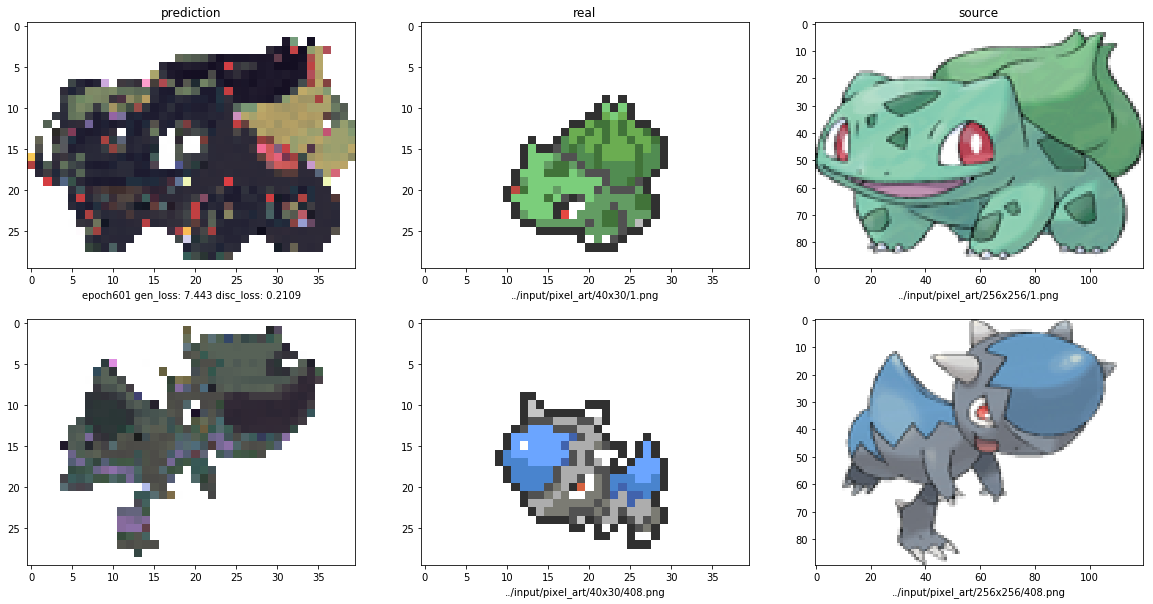

Epoch 601 Total time is 44.225215673446655 sec
Epoch 602 Total time is 42.484947681427 sec


KeyboardInterrupt: 

In [30]:
train(target_dataset,source_dataset,1000-602, 602, noise_dim)

In [26]:
!dir

DCGAN_pksprites.ipynb  Untitled.ipynb  get_started_workspace.ipynb  images


In [ ]:
checkpoint.save(file_prefix = "./saves/test")


In [ ]:
!dir


In [ ]:
generate_and_save_images(generator,0,
                               0.0,
                               0.0,
                               0.0
                              )

## Restore the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('aimage_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(598)

## Generate a GIF of all the saved images.

<!-- TODO(markdaoust): Remove the hack when Ipython version is updated -->


In [ ]:
with imageio.get_writer('dcgan.gif', mode='I', duration=0.1) as writer:
  filenames = glob.glob('aimage*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = i/5
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp dcgan.gif dcgan.gif.png')

In [ ]:
display.Image(filename="dcgan.gif.png")

In [ ]:
#@title Example form fields
#@markdown Forms support many types of fields.

no_type_checking = ''  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 125  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [ ]:
# load an example dataset
from vega_datasets import data
cars = data.cars()

# plot the dataset, referencing dataframe column names
import altair as alt
alt.Chart(cars).mark_bar().encode(
  x='mean(Miles_per_Gallon)',
  y='Origin',
  color='Origin'
)

To downlod the animation from Colab uncomment the code below:

In [ ]:
#from google.colab import files
#files.download('dcgan.gif')